This noteboook will guide you through the creation of a basic system in Springtronics.

# Imports

In [1]:
import sys
sys.path.append('../')

import Springtronics as spr
import matplotlib.pyplot as plt
import numpy as np

# Single oscillator

In [2]:
system = spr.MechanicalSystem()

Variables for the oscillator

In [3]:
m = 1
b= 2
k= 6
force = 1

print(f'Damping coefficient: {b/(2*np.sqrt(k*m))}')

Damping coefficient: 0.4082482904638631


Simulation variables

In [4]:
filelength = 78001
sr = 16000
x = np.linspace(0, filelength/sr, filelength)

In [5]:
dofName = 'oscillator'
system.degreesOfFreedom[f'{dofName}'] = spr.ParametricVariable(m) #creation of the dof
system.interactionPotentials[f'{dofName}_K'] =  spr.IntegerPotential(k) #spring
system.interactionPotentials[f'{dofName}_K'].degreesOfFreedom[dofName] = 2
system.interactionPotentials[f'{dofName}_B'] =  spr.LocalDamping(dofName, b) #damping

In [6]:
system.excitationSources['soundData'] = spr.DirectCInjectionSource(force) #constant force
system.interactionPotentials[f'excitation'] = spr.Excitation('oscillator', 'soundData', 1.0)

In [7]:
#probe
system.probes['oscillator'] = spr.WindowedA2Probe('oscillator',
                                                    startIndex=0,
                                                    endIndex=filelength)

# Define an adjoint source (used to compute the gradient efficiently: https://en.wikipedia.org/wiki/Adjoint_state_method)
system.interactionPotentials['oscillator_probe'] = system.probes['oscillator'].makeAdjointSource()

In [8]:
env = spr.CPPEnvironment(numSteps = filelength,
                           timeStep = 1.0/sr,
                           numSweepSteps = 1,
                           numThreads=1)
#simulation environment

In [9]:
traj = env.getTrajectories(system)

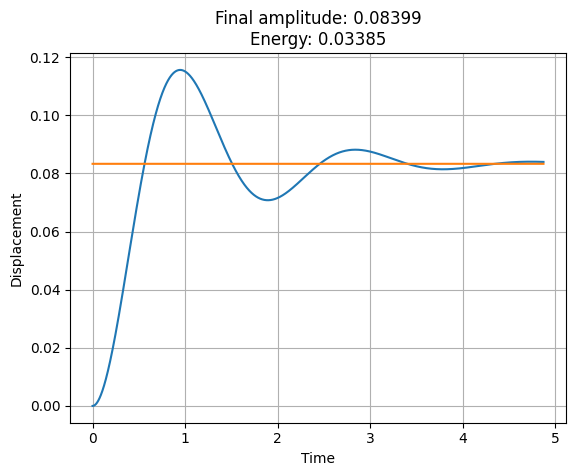

In [13]:
plt.plot(x, traj[:,0])
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.plot(x, force/(2*k)*np.ones(len(x)))
plt.title(f'Final amplitude: {round(traj[-1,0], 5)}\nEnergy: {round(traj[-1,2], 5)}')
plt.grid()

# Cantilever

We can add a cantilever and an optomechanical coupling to add a non linearity in the displacement

In [14]:
m_cant = 10
b_cant = 10
k_cant = 5
gamma = 10

In [15]:
dofName = 'cantilever'
system.degreesOfFreedom[f'{dofName}'] = spr.ParametricVariable(m_cant)
system.interactionPotentials[f'{dofName}_K'] =  spr.IntegerPotential(k_cant)
system.interactionPotentials[f'{dofName}_K'].degreesOfFreedom[dofName] = 2
#spring

system.interactionPotentials[f'{dofName}_B'] =  spr.LocalDamping(dofName, b_cant)

In [16]:
system.interactionPotentials[f'OptoCoup_oscillator_cantilever'] =  spr.IntegerPotential(-gamma)
system.interactionPotentials[f'OptoCoup_oscillator_cantilever'].degreesOfFreedom['oscillator'] = 2
system.interactionPotentials[f'OptoCoup_oscillator_cantilever'].degreesOfFreedom['cantilever'] = 1
#optomechanical coupling (gamma)

In [17]:
#probe cantilever
system.probes['cantilever'] = spr.WindowedA2Probe('cantilever',
                                                    startIndex=0,
                                                    endIndex=filelength)

# Define an adjoint source (used to compute the gradient efficiently: https://en.wikipedia.org/wiki/Adjoint_state_method)
system.interactionPotentials['cantilever_probe'] = system.probes['cantilever'].makeAdjointSource()

In [18]:
%%time
traj = env.getTrajectories(system, initialConditions=np.zeros(2), deleteTemp=False)

CPU times: user 417 µs, sys: 3.01 ms, total: 3.43 ms
Wall time: 306 ms


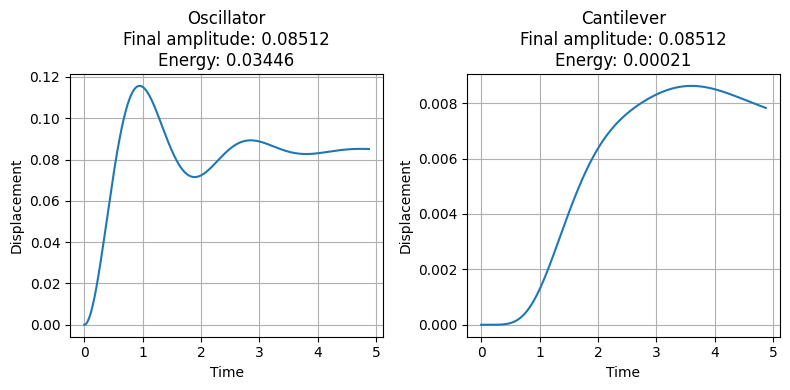

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].plot(x, traj[:,0])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Displacement')
axs[0].set_title(f'Oscillator\nFinal amplitude: {round(traj[-1,0], 5)}\nEnergy: {round(traj[-1,-2], 5)}')
axs[0].grid()

axs[1].plot(x, traj[:,1])
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Displacement')
axs[1].set_title(f'Cantilever\nFinal amplitude: {round(traj[-1,0], 5)}\nEnergy: {round(traj[-1,-1], 5)}')
axs[1].grid()

plt.tight_layout()

# Duffing

We can add a duffing potential to the cantilever

In [59]:
duffing  = 1e5 #lambda

In [60]:
dofName = 'cantilever'
system.interactionPotentials[f'{dofName}_L'] =  spr.IntegerPotential(duffing)
system.interactionPotentials[f'{dofName}_L'].degreesOfFreedom[dofName] = 4
#duffing potential (lambda)

In [61]:
traj_duffing = env.getTrajectories(system)

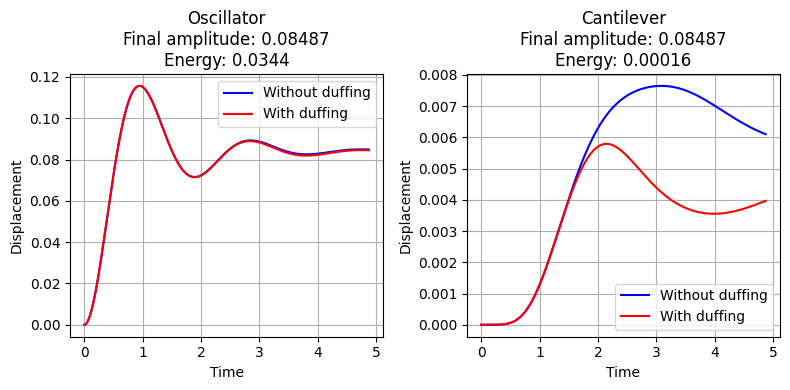

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].plot(x, traj[:,0], 'b', label='Without duffing')
axs[0].plot(x, traj_duffing[:,0], 'r', label='With duffing')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Displacement')
axs[0].set_title(f'Oscillator\nFinal amplitude: {round(traj[-1,0], 5)}\nEnergy: {round(traj[-1,-2], 5)}')
axs[0].grid()
axs[0].legend()

axs[1].plot(x, traj[:,1], 'b', label='Without duffing')
axs[1].plot(x, traj_duffing[:,1], 'r', label='With duffing')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Displacement')
axs[1].set_title(f'Cantilever\nFinal amplitude: {round(traj[-1,0], 5)}\nEnergy: {round(traj[-1,-1], 5)}')
axs[1].grid()
axs[1].legend()
plt.tight_layout()